<a href="https://colab.research.google.com/github/Equipe16-IAA/IAA012-FrameworksIA/blob/main/04_DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors (https://www.tensorflow.org/tutorials/generative/deepdream)

# 04 - Deepdream
# Exercício 04 - Deepdream

---

Esta prática contém uma implementação mínima do DeepDream, conforme descrito neste [post](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html), do blog de Alexander Mordvintsev.

Vamos demonstrar como fazer uma rede neural "sonhar" e aprimorar os padrões surreais que ela vê em uma imagem.


![Dogception](https://www.tensorflow.org/tutorials/generative/images/dogception.png)



---
### 1. Importação das bibliotecas

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

### 2. Importação da imagem

### Escolha uma imagem para "sonhar"

Para este tutorial, vamos usar uma imagem de um cachorro da raça [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg).


In [2]:
url = 'https://upload.wikimedia.org/wikipedia/commons/b/b6/Felis_catus-cat_on_snow.jpg'

2125399/2125399 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


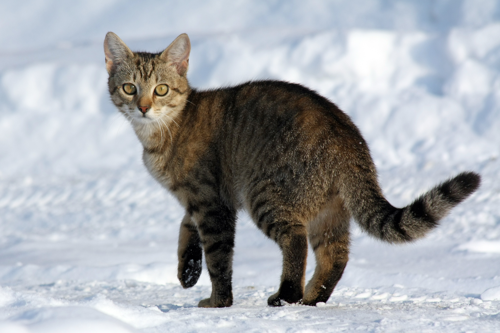

In [3]:
# Download da imagem e gravação em array Numpy
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalização da imagem
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Mostra a imagem
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Redução do tamanho da imagem para facilitar o trabalho da RNN
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))


### 3. Preparar o modelo de extração de recursos

Aqui faremos o download um modelo de classificação de imagem pré-treinado. Usaremos o [InceptionV3](https://keras.io/api/applications/inceptionv3/)  que é semelhante ao modelo originalmente usado no DeepDream. Observe que qualquer [modelo pré-treinado](https://keras.io/api/applications/#available-models) funcionará, embora você precise ajustar os nomes das camadas abaixo, caso deseje alterá-lo.

In [4]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### A ideia no DeepDream é escolher uma camada (ou camadas) e maximizar a "perda" de forma que a imagem cada vez mais treine as camadas.



In [5]:
# Maximizando as ativações das camadas
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Criação do modelo
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

### 4. Cálculo da perda (*loss*)

A perda é a soma das ativações nas camadas escolhidas.

In [6]:
def calc_loss(img, model):
  # Passe a imagem pelo modelo para recuperar as ativações.
  # Converte a imagem em um batch de tamanho 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

### 5. Subida de gradiente (*Gradient ascent*)

Depois de ter calculado a perda para as camadas escolhidas, tudo o que resta é calcular os gradientes em relação à imagem e adicioná-los à imagem original.

In [7]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)

      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # Gradientes relativos a img
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculo do gradiente da perda em relação aos pixels da imagem de entrada.
        gradients = tape.gradient(loss, img)

        # Normalizacao dos gradintes
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        # Na subida gradiente, a "perda" é maximizada.
        # Você pode atualizar a imagem adicionando diretamente os gradientes (porque eles têm o mesmo formato!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [8]:
deepdream = DeepDream(dream_model)

### 6. Circuito princial (*Main Loop*)

In [9]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):

  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

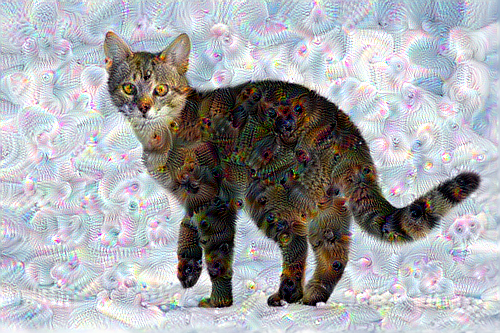

In [10]:
dream_img = run_deep_dream_simple(img=original_img,
                                  steps=100, step_size=0.01)

## 7. Levando o modelo até um oitava

Conseguimos gerar uma imagem. Porém, há alguns problemas com esta primeira tentativa:

  1. A saída é ruidosa (isso pode ser resolvido com uma perda  `tf.image.total_variation`).
  2. A imagem é de baixa resolução.
  3. Os padrões parecem estar acontecendo na mesma granularidade.


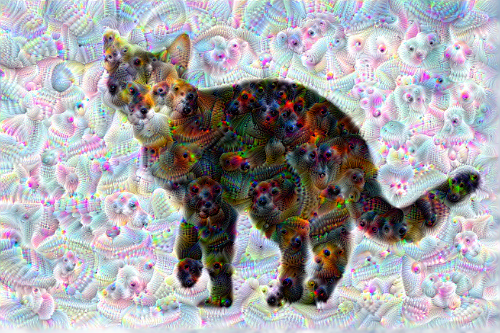

13.14780306816101

In [11]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

### Você pode alterar o número de oitavas, escala de oitavas e camadas ativadas para alterar a aparência da sua imagem do DeepDream.


---

# Fim do código